<h1>Popular Steam Game Sentiment Analysis</h1>
Citation </br>
Antoni Sobkowicz. (2017). Steam Review Dataset (2017) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.1000885

License
CC BY NC 4.0|

# 1. Install & Import Necessary Libray For NLP and Sentiment Analysis

In [1]:
# %pip install stopwords
# %pip install flair
# %pip install nltk
# %pip install swifter
# %pip install wordcloud




In [2]:
import pandas as pd
import numpy as np
import re
import nltk
# nltk.download()

from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random as rn
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter
from PIL import Image
pd.options.display.max_rows = None

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,classification_report
# from scikitplot.metrics import plot_confusion_matrix

import warnings
warnings.filterwarnings('ignore')

# 2. Import Steam Games Review Dataset

app_id       -> Game ID <br/>
app_name     -> Game Name <br/>
review_text  -> Review text <br/>
review_score -> Review Sentiment: whether the game the review recommends the game or not. [1: Yes, -1: No, 0: None] <br/>
review_votes -> Review vote  : whether the review was recommended by another user or not. [1: Yes, 0: No] <br/>

In [3]:
df = pd.read_csv('dataset.csv')
df.head()

,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,Ruined my life.,1,0
1,10,Counter-Strike,This will be more of a ''my experience with th...,1,1
2,10,Counter-Strike,This game saved my virginity.,1,0
3,10,Counter-Strike,• Do you like original games? • Do you like ga...,1,0
4,10,Counter-Strike,"Easy to learn, hard to master.",1,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6417106 entries, 0 to 6417105
Data columns (total 5 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   app_id        int64 
 1   app_name      object
 2   review_text   object
 3   review_score  int64 
 4   review_votes  int64 
dtypes: int64(3), object(2)
memory usage: 244.8+ MB


In [5]:
# Since the dataset contains 6.4m data, I planned to 
# scale down the dataset to <100,000 entries.

# Check the amount of review from rach game
df['app_name'].value_counts(ascending=False, dropna=True).head()

PAYDAY 2    88973
DayZ        88850
Terraria    84828
Rust        77037
Dota 2      73541
Name: app_name, dtype: int64

In [6]:
# Since PAYDAY 2 has the most review and contains 88973 entries, 
# I decided to make sentiment analysis on the chosen game - PAYDAY 2.

#Create payday2 dataframe
payday2_df = df[df['app_name'] == 'PAYDAY 2'].reset_index(drop=True)
payday2_df.head()

,app_id,app_name,review_text,review_score,review_votes
0,218620,PAYDAY 2,Well what can i say. I got 1200h+ Hours played...,-1,1
1,218620,PAYDAY 2,Update: It appears that Starbreeze has purchas...,-1,1
2,218620,PAYDAY 2,Another game that goes sour because of a cashg...,-1,1
3,218620,PAYDAY 2,"I used to like you, OVERKILL. Your game was gr...",-1,1
4,218620,PAYDAY 2,The public play is a toxic and unpleasant to p...,-1,1


In [7]:
# Generate paydy2_dataset.csv file that help to load faster in further use
payday2_df.to_csv('payday2_dataset.csv')

## Load payday2_dataset.csv dataset

In [8]:
payday2_df = pd.read_csv('payday2_dataset.csv', index_col=[0])
payday2_df.head()

,app_id,app_name,review_text,review_score,review_votes
0,218620,PAYDAY 2,Well what can i say. I got 1200h+ Hours played...,-1,1
1,218620,PAYDAY 2,Update: It appears that Starbreeze has purchas...,-1,1
2,218620,PAYDAY 2,Another game that goes sour because of a cashg...,-1,1
3,218620,PAYDAY 2,"I used to like you, OVERKILL. Your game was gr...",-1,1
4,218620,PAYDAY 2,The public play is a toxic and unpleasant to p...,-1,1


In [9]:
payday2_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88973 entries, 0 to 88972
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   app_id        88973 non-null  int64 
 1   app_name      88973 non-null  object
 2   review_text   88783 non-null  object
 3   review_score  88973 non-null  int64 
 4   review_votes  88973 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 4.1+ MB


In [10]:
payday2_df['review_text'] = payday2_df['review_text'].astype('str')


In [11]:
payday2_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88973 entries, 0 to 88972
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   app_id        88973 non-null  int64 
 1   app_name      88973 non-null  object
 2   review_text   88973 non-null  object
 3   review_score  88973 non-null  int64 
 4   review_votes  88973 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 4.1+ MB


# 3. EDA (Analysis and Visualization)

## Distribution of Reviews in Each Sentiment

In [12]:
temp = payday2_df.groupby('review_score').count()['review_text'].reset_index().sort_values(by='review_text',ascending=False)
temp.style.background_gradient(cmap='ocean')

,review_score,review_text
1,1,61765
0,-1,27208


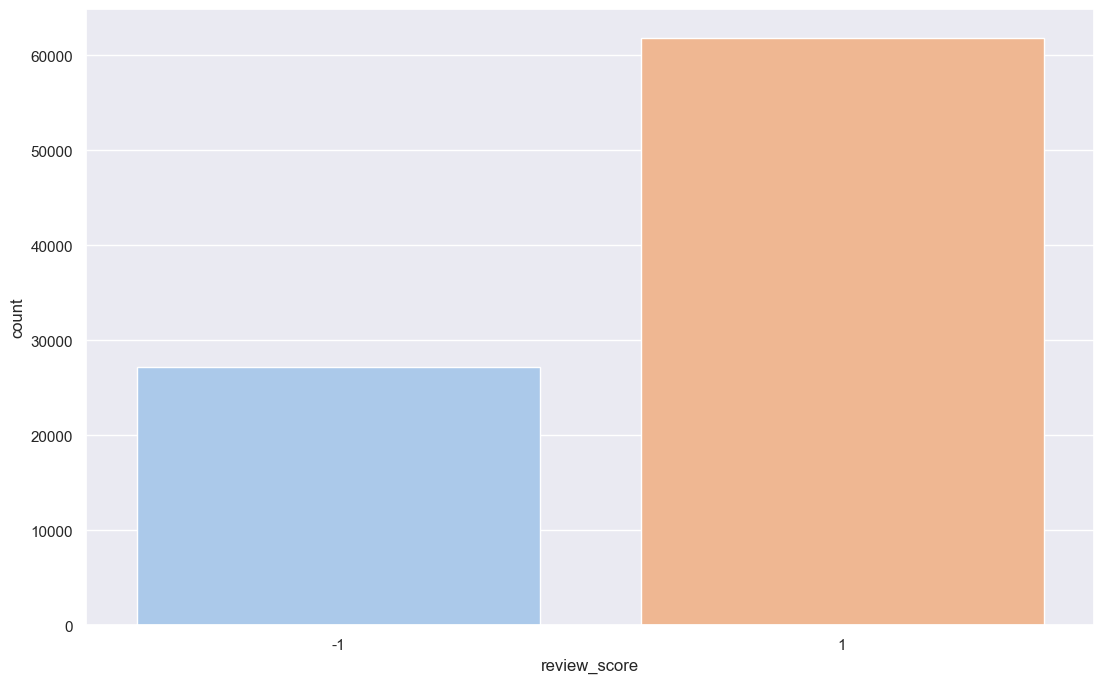

In [13]:
# We will see the visualization of it.
sns.set_theme(style='whitegrid')
sns.set(rc = {'figure.figsize':(13,8)})
sns.set_palette("pastel")
sns.countplot(x='review_score',data=payday2_df);

### Conclude: Amount of Positive > Negative
We can see that there are more positive sentiment reviews than negative sentiment reviews.

## WordCloud of Our Review Text

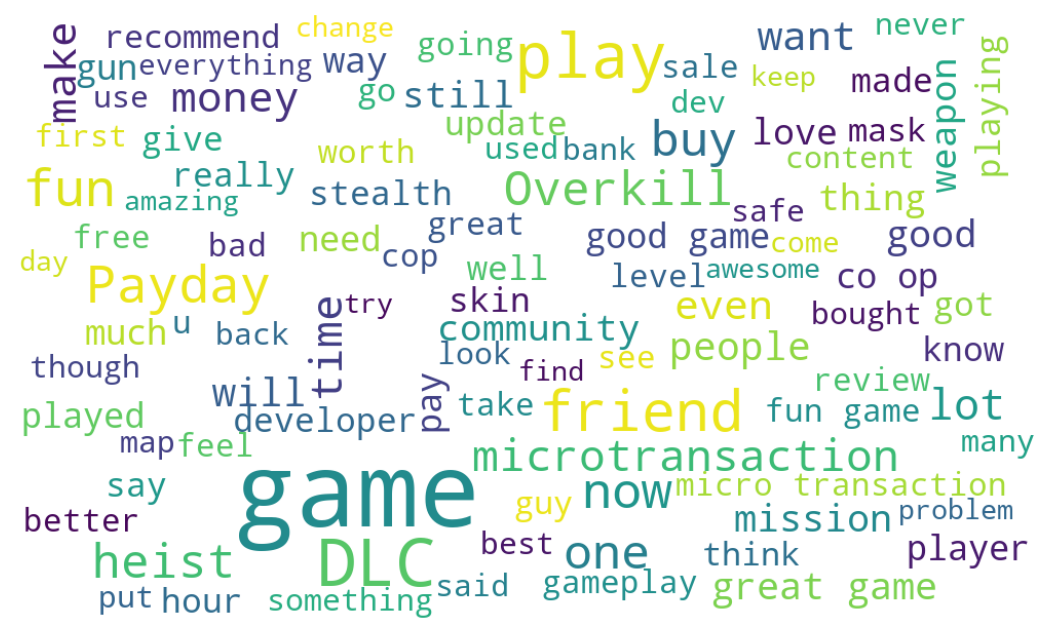

In [14]:
txt = ' '.join(rev for rev in payday2_df.review_text)
plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            background_color = 'white',
            max_font_size = 100,
            max_words = 100,
            width = 1000,
            height = 600
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

### WordCloud of Each Sentiment Review Text

In [15]:
positive = payday2_df[payday2_df['review_score']==1]
negative = payday2_df[payday2_df['review_score']==-1]

#### Positive Sentiment Reviews

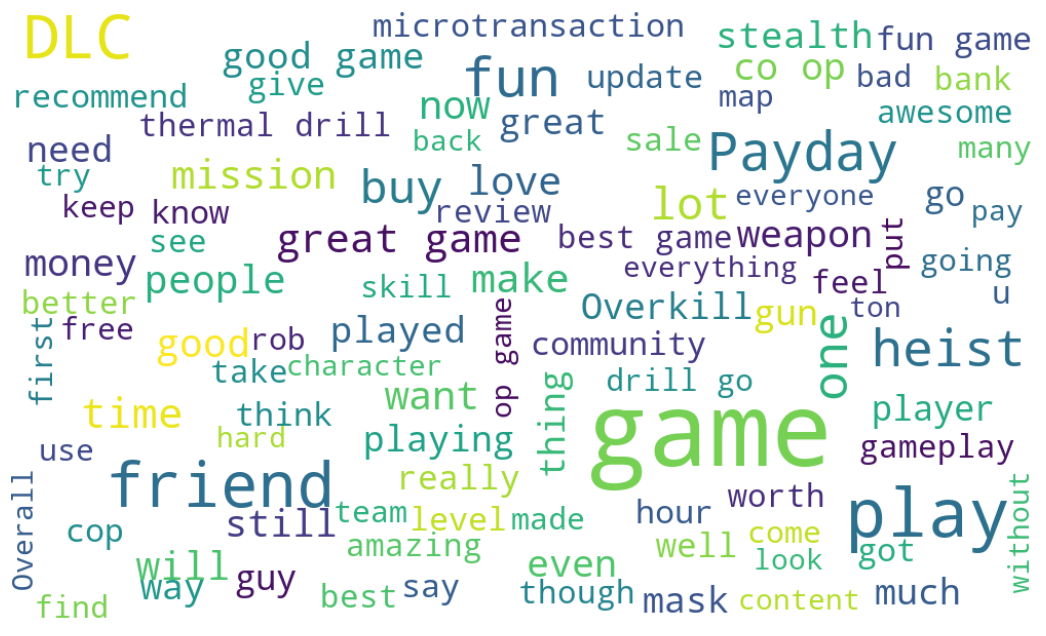

In [16]:
# Positive Sentiment Reviews
txt = ' '.join(rev for rev in positive.review_text)
plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            background_color = 'white',
            max_font_size = 100,
            max_words = 100,
            width = 1000,
            height = 600
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

#### Negative Sentiment Reviews

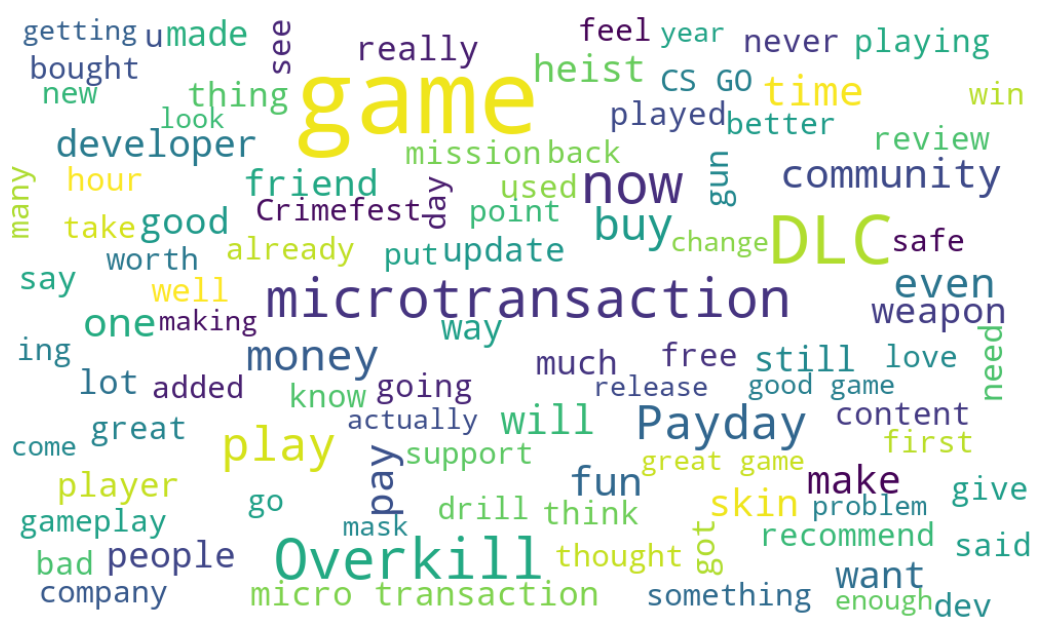

In [42]:
txt = ' '.join(rev for rev in negative.review_text)
plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            background_color = 'white',
            max_font_size = 100,
            max_words = 100,
            width = 1000,
            height = 600
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

#### Conclude on both Sentiment Reviews
And we can see that for negative sentiment review, the most common words are 'boring', 'worth', 'bad', 'game', etc as shown in picture above. It seems for game review, the reviews are a little bit different than reviews for usable or consumable products or goods.¶

From the both wordclouds of each sentiment above we can see that there are words like "early" or "access" that dominate our review words. We will drop them.

## Distribution of Number of Review Words

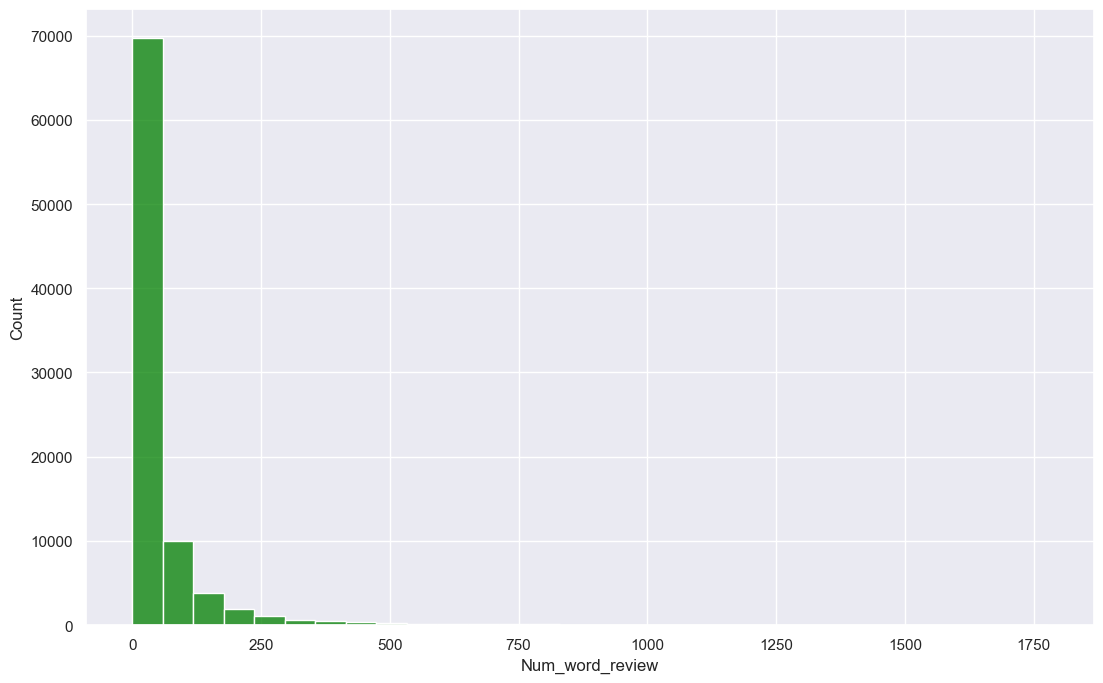

In [18]:
review_vis = payday2_df.copy()
review_vis['Num_word_review'] = review_vis['review_text'].apply(lambda x:len(str(x).split()))

sns.histplot(data=review_vis, x="Num_word_review",bins=30,color='green');

### Observation on Result
As we can see that most of our review texts contain 1-250 words.

## Distribution of Words in All Review Texts

In [19]:
review_vis['temp_list'] = review_vis['review_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in review_vis['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,the,171772
1,to,118700
2,and,113520
3,a,109881
4,of,84628
5,game,80477
6,you,72313
7,is,67803
8,I,61462
9,this,52637


### Conclude on Observation
Of course this list still contains stopwords which we have not filtered yet. We will see them later after we filter our review texts

# 4. Data Cleaning For Sentiment Processing

In [56]:
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
nltk.download('stopwords')
from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ron\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Basic Cleaning
### Remove Null values 

In [58]:
payday2_df.isnull().sum()

app_id          0
app_name        0
review_text     0
review_score    0
review_votes    0
dtype: int64

### Remove Duplicate Values

In [59]:
review = payday2_df.drop_duplicates(keep='first')

In [60]:
review.shape

(63577, 5)

## Enhanced Cleaning

#### Remove hyperlinks and markup

In [61]:
def clean(raw):
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result)
    result = re.sub('&#x27;', "'", result)
    result = re.sub('&quot;', '"', result)
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result)
    result = re.sub('</i>', '', result)
    result = re.sub('&#62;', '', result)
    result = re.sub('<i>', ' ', result)
    result = re.sub("\n", '', result)
    return result

#### Remove Numeric

In [62]:
def remove_num(texts):
   output = re.sub(r'\d+', '', texts)
   return output

#### Remove Emoji

In [63]:
def deEmojify(x):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', x)

#### Remove Symbols

In [65]:
def remove_symbols(x):
    cleaned_string = re.sub(r"[^a-zA-Z0-9?!.,]+", ' ', x)
    return cleaned_string

#### Remove Punctuation

In [66]:
def remove_punctuation(text):
    final = "".join(u for u in text if u not in ("?", ".", ";", ":",  "!",'"',','))
    return final

#### Remove Stopwords

In [67]:
stop=set(stopwords.words("english"))
stemmer=PorterStemmer()
lemma=WordNetLemmatizer()

def remove_stopword(text):
   text=[word.lower() for word in text.split() if word.lower() not in stop]
   return " ".join(text)

#### Unify Whitespaces

In [64]:
def unify_whitespaces(x):
    cleaned_string = re.sub(' +', ' ', x)
    return cleaned_string 

#### Normalize words using Stemming

In [68]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
def Stemming(text):
   stem=[]
   stopword = stopwords.words('english')
   snowball_stemmer = SnowballStemmer('english')
   word_tokens = nltk.word_tokenize(text)
   stemmed_word = [snowball_stemmer.stem(word) for word in word_tokens]
   stem=' '.join(stemmed_word)
   return stem

In [69]:
def cleaning(df,review):
    df[review] = df[review].apply(clean)
    df[review] = df[review].apply(deEmojify)
    df[review] = df[review].str.lower()
    df[review] = df[review].apply(remove_num)
    df[review] = df[review].apply(remove_symbols)
    df[review] = df[review].apply(remove_punctuation)
    df[review] = df[review].apply(remove_stopword)
    df[review] = df[review].apply(unify_whitespaces)
    df[review] = df[review].apply(Stemming)

cleaning(review,'review_text')
review[['review_text']].head(20)

,review_text
0,well say got h hour play yes bought complet ov...
1,updat appear starbreez purchas right game away...
2,anoth game goe sour cashgrab publish develop u...
3,use like overkil game great recent activ seem ...
4,public play toxic unpleas play peopl dont know...
5,good way ruin playerbas add microtransact payd...
6,made clear payday micro transact whatsoev sham...
7,year old player work hard buy game bought ever...
8,payday great game simpl fun game rob bank make...
9,download content fest caus game keep get inste...


## Conclude: After Cleaning
 Now all the cleanings are done. We will try to visualize the common words distribution of our review texts. We have done it before but our previous review texts still contain stopwords and punctuations.

In [73]:
review_vis2 = review.copy()
review_vis2['temp_list'] = review_vis2['review_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in review_vis2['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')


,Common_words,count
0,game,93468
1,play,27583
2,dlc,22160
3,get,22062
4,fun,16894
5,like,16248
6,payday,15581
7,good,14681
8,heist,12492
9,buy,12390


<AxesSubplot:xlabel='count', ylabel='Common_words'>

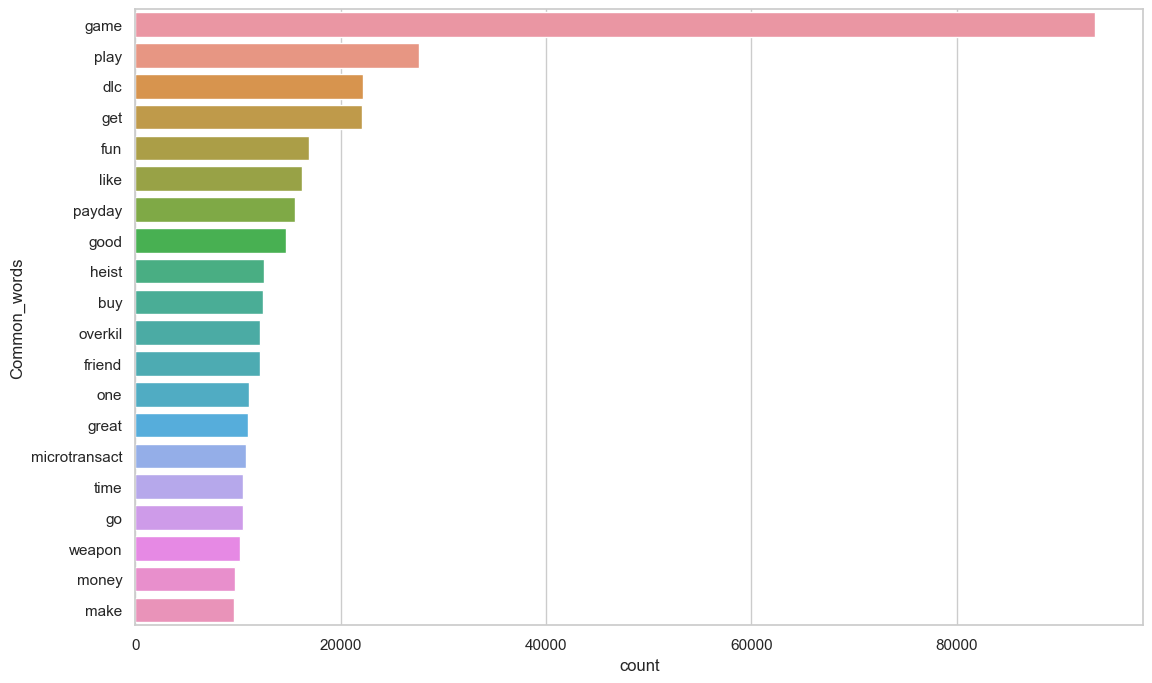

In [74]:
sns.set_theme(style="whitegrid")
sns.barplot(x="count", y="Common_words", data=temp)

# 5. Creating Bag of Words and Text Classifier Model
## Creating pipeline for tokenizing and modelling

In [75]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
clf = Pipeline([
    ('vect', CountVectorizer(stop_words= "english",max_features=4000)),
    ('tfidf', TfidfTransformer()),
    ('classifier', RandomForestClassifier()),
    ])

In [76]:
X = review['review_text']
y = review['review_score']

In [77]:
from collections import Counter
Counter(y)

Counter({-1: 19605, 1: 43972})

## Tokenizing and Model Training

In [78]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state = 23,
                                                   test_size = 0.20)

In [79]:
text_classifier = clf.fit(X_train,y_train)

In [80]:
predictions = text_classifier.predict(X_test)

In [81]:
np.unique(predictions)

array([-1,  1], dtype=int64)

## Test Model's Performance

In [82]:
# find accuracy, precision, recall:
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import f1_score, accuracy_score, plot_confusion_matrix, roc_auc_score
confusion_matrix(y_test,predictions)

array([[2772, 1096],
       [ 711, 8137]], dtype=int64)

In [83]:
def Confusion_Matrix(y_test,ypred):
    cfmat = confusion_matrix(y_test,ypred)
    print('Confusion Matrix: \n',classification_report(y_test,ypred,labels=[1,-1]))
    print("\n")
    print('TN - True Negative {}'.format(cfmat[1,1]))
    print('FP - False Positive {}'.format(cfmat[1,0]))
    print('FN - False Negative {}'.format(cfmat[0,1]))
    print('TP - True Positive {}'.format(cfmat[0,0]))
    print('Accuracy Rate: {}'.format(np.divide(np.sum([cfmat[0,0],cfmat[1,1]]),np.sum(cfmat))))
    print('Misclassification Rate: {}'.format(np.divide(np.sum([cfmat[0,1],cfmat[1,0]]),np.sum(cfmat))))
    print('F1-Score: {}'.format(f1_score(y_test, ypred,average='macro')))
    print('ROC-AUC {}'.format(roc_auc_score(y_test,ypred)))

In [84]:
Confusion_Matrix(y_test,predictions)

Confusion Matrix: 
               precision    recall  f1-score   support

           1       0.88      0.92      0.90      8848
          -1       0.80      0.72      0.75      3868

    accuracy                           0.86     12716
   macro avg       0.84      0.82      0.83     12716
weighted avg       0.86      0.86      0.86     12716



TN - True Negative 8137
FP - False Positive 711
FN - False Negative 1096
TP - True Positive 2772
Accuracy Rate: 0.8578955646429695
Misclassification Rate: 0.14210443535703052
F1-Score: 0.8271219708413065
ROC-AUC 0.8181461441867337


<AxesSubplot:>

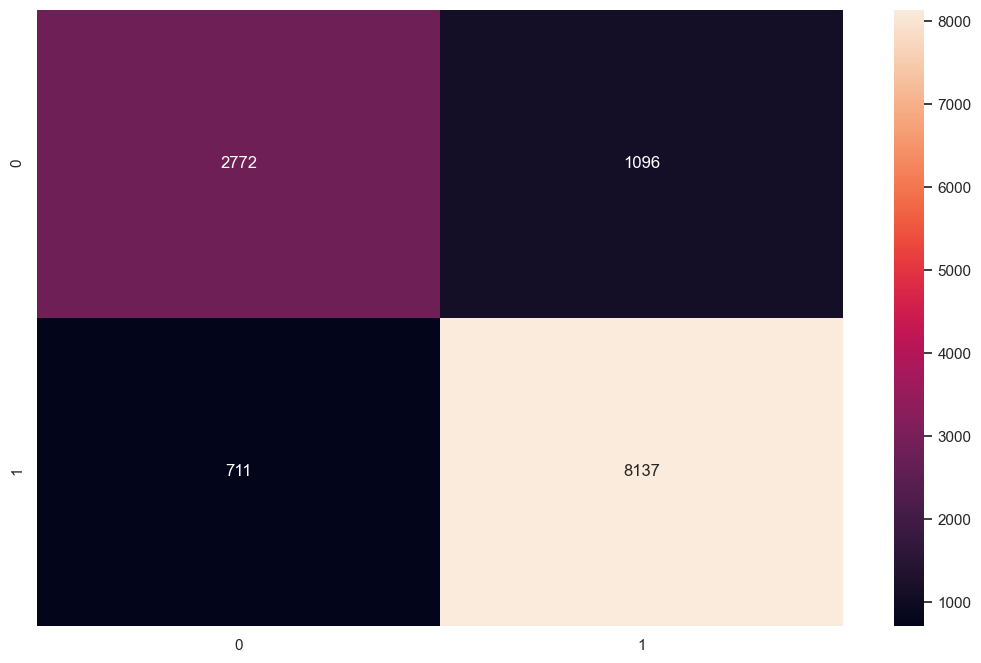

In [85]:
sns.heatmap(confusion_matrix(y_test,predictions),annot=True,fmt='')

We see from above confusion matrix that our model has accuracy of 85.6 % and F1-Score of 0.678. It is not good because our data is highly imbalanced. Our model has high accuracy because it computes accuracy of prediction on majority class. After putting our attention to F1-Score, we can understand that our data is poorly at predicting negative class.

We also have ROC-AUC score of 0.64. So there is a high chance that the our text classifier model WILL NOT be able to distinguish the positive sentiment class values from the negative sentiment class values.